<a href="https://colab.research.google.com/github/zrruziev/deep_learning_practice/blob/main/TENSORFLOW/text_classification_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

[Official Link](https://keras.io/examples/nlp/text_classification_with_transformer/) | [Transformer embeddings and tokenization](https://vaclavkosar.com/ml/transformer-embeddings-and-tokenization)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pprint import pprint

# Implement embedding + positional encoding layer
Two seperate embedding layers, one for tokens, one for token index (positions).

In [2]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
#         print(f"positions: {positions.shape}")
        positions = self.pos_emb(positions)
#         print(f"pos_emb: {positions.shape}")
        x = self.token_emb(x)
        return x + positions

# Implement a Transformer block as a layer

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
#         pprint(f"Attention Configs:{self.att.get_config()}")
        

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
#         print(f"\ninput: {inputs.shape}\noutput: {self.layernorm2(out1 + ffn_output).shape}")
        return self.layernorm2(out1 + ffn_output)

# Download and prepare dataset

In [4]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)

print(f"train_shape: {x_train.shape}")
print(f"\nx_train[0] = \n\n{x_train[0]}")
print(f"\n\nx_val[0] = \n\n{x_val[0]}")

17464789/17464789 [==============================] - 2s 0us/step
25000 Training sequences
25000 Validation sequences
train_shape: (25000, 200)

x_train[0] = 

[    5    25   100    43   838   112    50   670     2     9    35   480
   284     5   150     4   172   112   167     2   336   385    39     4
   172  4536  1111    17   546    38    13   447     4   192    50    16
     6   147  2025    19    14    22     4  1920  4613   469     4    22
    71    87    12    16    43   530    38    76    15    13  1247     4
    22    17   515    17    12    16   626    18 19193     5    62   386
    12     8   316     8   106     5     4  2223  5244    16   480    66
  3785    33     4   130    12    16    38   619     5    25   124    51
    36   135    48    25  1415    33     6    22    12   215    28    77
    52     5    14   407    16    82 10311     8     4   107   117  5952
    15   256     4     2     7  3766     5   723    36    71    43   530
   476    26   400   317    46     7  

# Create classifier model using transformer layer
Transformer layer outputs one vector for each time step of our input sequence. Here, we take the mean across all time steps and use a feed forward network on top of it to classify text.

In [5]:
tf.keras.backend.clear_session()

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          646400    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 200, 32)          10656     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

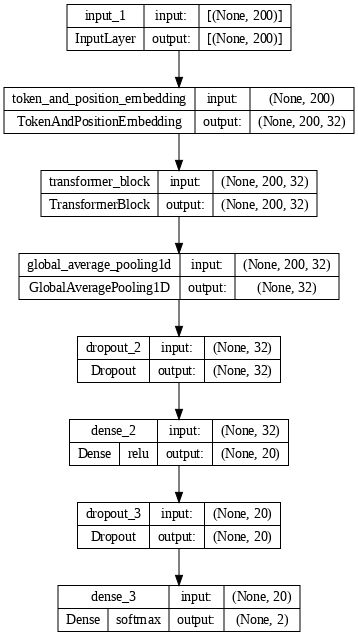

In [6]:
tf.keras.utils.plot_model(model, 'txt_cls_transformers.png', dpi=72,show_shapes=True, show_layer_activations=True)

# Train and Evaluate

In [7]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x_train,
                    y_train,
                    batch_size=32,
                    epochs=5,
                    validation_data=(x_val, y_val)
                   )

Epoch 1/5
782/782 [==============================] - 12s 11ms/step - loss: 0.3866 - accuracy: 0.8140 - val_loss: 0.2855 - val_accuracy: 0.8815
Epoch 2/5
782/782 [==============================] - 9s 11ms/step - loss: 0.1977 - accuracy: 0.9248 - val_loss: 0.3200 - val_accuracy: 0.8729
Epoch 3/5
782/782 [==============================] - 8s 11ms/step - loss: 0.1275 - accuracy: 0.9552 - val_loss: 0.3977 - val_accuracy: 0.8599
Epoch 4/5
782/782 [==============================] - 8s 11ms/step - loss: 0.0826 - accuracy: 0.9733 - val_loss: 0.4447 - val_accuracy: 0.8474
Epoch 5/5
782/782 [==============================] - 8s 11ms/step - loss: 0.0572 - accuracy: 0.9821 - val_loss: 0.6070 - val_accuracy: 0.8388
